In [2]:
import datetime

In [4]:
def parse_first_brewed(text: str) -> datetime.date:
    parts = text.split('/')
    if len(parts) == 2:
        return datetime.date(int(parts[1]), int(parts[0]), 1)
    elif len(parts) == 1:
        return datetime.date(int(parts[0]), 1, 1)
    else:
        assert False, 'Unknown date format'

In [5]:
parse_first_brewed('09/2007')

datetime.date(2007, 9, 1)

In [6]:
parse_first_brewed('2007')

datetime.date(2007, 1, 1)

# Fetch the Data

In [11]:
# The API provides paged results. To encapsulate the paging, 
# we create a generator that yields beers one by one:
from typing import Iterator, Dict, Any
from urllib.parse import urlencode
import requests

def iter_beers_from_api(page_size: int = 5) -> Iterator[Dict[str, Any]]:
    session = requests.Session()
    page = 1
    while True:
        response = session.get('https://api.punkapi.com/v2/beers?' + urlencode({
            'page': page,
            'per_page': page_size
        }))
        response.raise_for_status()
        
        data = response.json()
        if not data:
            break
            
        yield from data
        
        page += 1

In [12]:
# And to use the generator function, we call and iterate it:
beers = iter_beers_from_api()
next(beers)

{'id': 1,
 'name': 'Buzz',
 'tagline': 'A Real Bitter Experience.',
 'first_brewed': '09/2007',
 'description': 'A light, crisp and bitter IPA brewed with English and American hops. A small batch brewed only once.',
 'image_url': 'https://images.punkapi.com/v2/keg.png',
 'abv': 4.5,
 'ibu': 60,
 'target_fg': 1010,
 'target_og': 1044,
 'ebc': 20,
 'srm': 10,
 'ph': 4.4,
 'attenuation_level': 75,
 'volume': {'value': 20, 'unit': 'litres'},
 'boil_volume': {'value': 25, 'unit': 'litres'},
 'method': {'mash_temp': [{'temp': {'value': 64, 'unit': 'celsius'},
    'duration': 75}],
  'fermentation': {'temp': {'value': 19, 'unit': 'celsius'}},
  'twist': None},
 'ingredients': {'malt': [{'name': 'Maris Otter Extra Pale',
    'amount': {'value': 3.3, 'unit': 'kilograms'}},
   {'name': 'Caramalt', 'amount': {'value': 0.2, 'unit': 'kilograms'}},
   {'name': 'Munich', 'amount': {'value': 0.4, 'unit': 'kilograms'}}],
  'hops': [{'name': 'Fuggles',
    'amount': {'value': 25, 'unit': 'grams'},
    '

In [13]:
next(beers)

{'id': 2,
 'name': 'Trashy Blonde',
 'tagline': "You Know You Shouldn't",
 'first_brewed': '04/2008',
 'description': 'A titillating, neurotic, peroxide punk of a Pale Ale. Combining attitude, style, substance, and a little bit of low self esteem for good measure; what would your mother say? The seductive lure of the sassy passion fruit hop proves too much to resist. All that is even before we get onto the fact that there are no additives, preservatives, pasteurization or strings attached. All wrapped up with the customary BrewDog bite and imaginative twist.',
 'image_url': 'https://images.punkapi.com/v2/2.png',
 'abv': 4.1,
 'ibu': 41.5,
 'target_fg': 1010,
 'target_og': 1041.7,
 'ebc': 15,
 'srm': 15,
 'ph': 4.4,
 'attenuation_level': 76,
 'volume': {'value': 20, 'unit': 'litres'},
 'boil_volume': {'value': 25, 'unit': 'litres'},
 'method': {'mash_temp': [{'temp': {'value': 69, 'unit': 'celsius'},
    'duration': None}],
  'fermentation': {'temp': {'value': 18, 'unit': 'celsius'}},
 

You will notice that the first result of each page takes a bit longer. This is because it does a network request to fetch the page.

# Create a Table in the Database

In [14]:
# createdb -O alena testload

In [16]:
import psycopg2
# conn = psycopg2.connect("host=127.0.0.1 dbname=sparkifydb user=alena password=12345")
connection = psycopg2.connect(
    host='localhost',
    dbname='udacity',
    user='alena',
    password='12345',
    )
connection.autocommit = True

In [25]:
# The function receives a cursor and creates a unlogged table 
# called staging_beers.

def create_staging_table(cursor) -> None:
    cursor.execute("""
        DROP TABLE IF EXISTS staging_beers;
        CREATE UNLOGGED TABLE staging_beers (
            id                  INTEGER,
            name                TEXT,
            tagline             TEXT,
            first_brewed        DATE,
            description         TEXT,
            image_url           TEXT,
            abv                 DECIMAL,
            ibu                 DECIMAL,
            target_fg           DECIMAL,
            target_og           DECIMAL,
            ebc                 DECIMAL,
            srm                 DECIMAL,
            ph                  DECIMAL,
            attenuation_level   DECIMAL,
            brewers_tips        TEXT,
            contributed_by      TEXT,
            volume              INTEGER
        );
    """)

Data written to an unlogged table will not be logged to the write-ahead-log (WAL), making it ideal for intermediate tables. Note that UNLOGGED tables will not be restored in case of a crash, and will not be replicated.

In [26]:
with connection.cursor() as cursor:
    create_staging_table(cursor)

# Metrics

Throughout this article we are interested in two main metrics: time and memory.

## Measuring Time

To measure time for each method we use the built-in [time module](https://docs.python.org/3/library/time.html):

In [27]:
import time
start = time.perf_counter()
time.sleep(1) # do work
elapsed = time.perf_counter() - start
print(f'Time {elapsed:0.4}')

Time 1.001


The function perf_counter provides the clock with the highest available resolution, which makes it ideal for our purposes.

## Measuring Memory

To measure memory consumption, we are going to use the package [memory-profiler](https://pypi.org/project/memory-profiler/).

In [33]:
# from memory_profiler import memory_usage

# mem, retval = memory_usage((fn, args, kwargs), retval=True, interval=1e-7)

## profile Decorator

To put it all together, we create the following decorator to measure and report time and memory:

In [31]:
import time
from functools import wraps
from memory_profiler import memory_usage

def profile(fn):
    @wraps(fn)
    def inner(*args, **kwargs):
        fn_kwargs_str = ', '.join(f'{k}={v}' for k, v in kwargs.items())
        print(f'\n{fn.__name__}({fn_kwargs_str})')

        # Measure time
        t = time.perf_counter()
        retval = fn(*args, **kwargs)
        elapsed = time.perf_counter() - t
        print(f'Time   {elapsed:0.4}')

        # Measure memory
        mem, retval = memory_usage((fn, args, kwargs), retval=True, timeout=200, interval=1e-7)

        print(f'Memory {max(mem) - min(mem)}')
        return retval

    return inner

To eliminate mutual effects of the timing on the memory and vice versa, we execute the function twice. First to time it, second to measure the memory usage.<br><br>
The decorator will print the function name and any keyword arguments, and report the time and memory used:

In [32]:
@profile
def work(n):
    for i in range(n):
        2 ** n
        
work(10)


work()
Time   7.4e-06
Memory 0.0703125


In [34]:
work(n=1000)


work(n=1000)
Time   0.001204
Memory 0.0


Only keywords arguments are printed. This is intentional, we are going to use that in parameterized tests.

# Benchmark

At the time of writing, the beers API contains only 325 beers. To work on a large dataset, we duplicate it 100 times and store it in-memory. The resulting dataset contains 32,500 beers:

In [36]:
beers = list(iter_beers_from_api()) * 100
len(beers)

32500

To imitate a remote API, our functions will accept iterators similar to the return value of iter_beers_from_api

In [ ]:
def process(beers: Iterator[Dict[str, Any]]) -> None:
    # Process beers...

For the benchmark, we are going to import the beer data into the database. To eliminate external influences such as the network, we fetch the data from the API in advance, and serve it locally.<br><br>
To get an accurate timing, we "fake" the remote API:

In [37]:
beers = list(iter_beers_from_api()) * 100
process(beers)

NameError: name 'process' is not defined

In a real life situation you would use the function iter_beers_from_api directly:

In [39]:
# process(iter_beers_from_api())

# Insert Rows One by One

To establish a baseline we start with the simplest approach, insert rows one by one:

In [41]:
@profile
def insert_one_by_one(connection, beers: Iterator[Dict[str, Any]]) -> None:
    with connection.cursor() as cursor:
        create_staging_table(cursor)
        for beer in beers:
            cursor.execute("""
                INSERT INTO staging_beers VALUES (
                    %(id)s,
                    %(name)s,
                    %(tagline)s,
                    %(first_brewed)s,
                    %(description)s,
                    %(image_url)s,
                    %(abv)s,
                    %(ibu)s,
                    %(target_fg)s,
                    %(target_og)s,
                    %(ebc)s,
                    %(srm)s,
                    %(ph)s,
                    %(attenuation_level)s,
                    %(brewers_tips)s,
                    %(contributed_by)s,
                    %(volume)s
                );
            """, {
                **beer,
                'first_brewed': parse_first_brewed(beer['first_brewed']),
                'volume': beer['volume']['value'],
            })


Notice that as we iterate the beers, we transform the first_brewed to a datetime.date and extracted the volume value from the nested volume field.

Running this function produces the following output:

In [42]:
insert_one_by_one(connection, beers)


insert_one_by_one()
Time   5.761
Memory 0.0078125


The function took 129 seconds to import 32K rows. The memory profiler shows that the function consumed very little memory.

Intuitively, inserting rows one by one does not sound very efficient. The constant context switching between the program and the database must be slowing it down.

## Execute Many

Psycopg2 provides a way to insert many rows at once using [executemany](http://initd.org/psycopg/docs/cursor.html#cursor.executemany). From the docs:

In [44]:
@profile
def insert_executemany(connection, beers: Iterator[Dict[str, Any]]) -> None:
    with connection.cursor() as cursor:
        create_staging_table(cursor)

        all_beers = [{
            **beer,
            'first_brewed': parse_first_brewed(beer['first_brewed']),
            'volume': beer['volume']['value'],
        } for beer in beers]

        cursor.executemany("""
            INSERT INTO staging_beers VALUES (
                %(id)s,
                %(name)s,
                %(tagline)s,
                %(first_brewed)s,
                %(description)s,
                %(image_url)s,
                %(abv)s,
                %(ibu)s,
                %(target_fg)s,
                %(target_og)s,
                %(ebc)s,
                %(srm)s,
                %(ph)s,
                %(attenuation_level)s,
                %(brewers_tips)s,
                %(contributed_by)s,
                %(volume)s
            );
        """, all_beers)

The function looks very similar to the previous function, and the transformations are the same. The main difference here is that we first **transform all of the data in-memory, and only then import it to the database.**

Running this function produces the following output:

In [45]:
insert_executemany(connection, beers)


insert_executemany()
Time   5.472
Memory 0.15625


This is disappointing. The timing is just a little bit better, but the function now consumes 2.7MB of memory.(in my case it's 156KB)

To put the memory usage in perspective, a JSON file containing only the data we import weighs 25MB on disk. Considering the proportion, using this method to import a 1GB file will require 110MB of memory.

## Execute Many From Iterator

The previous method consumed a lot of memory because the transformed data was stored in-memory before being processed by psycopg.

Let's see if we can use an iterator to avoid storing the data in-memory:

In [47]:
@profile
def insert_executemany_iterator(connection, beers: Iterator[Dict[str, Any]]) -> None:
    with connection.cursor() as cursor:
        create_staging_table(cursor)
        cursor.executemany("""
            INSERT INTO staging_beers VALUES (
                %(id)s,
                %(name)s,
                %(tagline)s,
                %(first_brewed)s,
                %(description)s,
                %(image_url)s,
                %(abv)s,
                %(ibu)s,
                %(target_fg)s,
                %(target_og)s,
                %(ebc)s,
                %(srm)s,
                %(ph)s,
                %(attenuation_level)s,
                %(brewers_tips)s,
                %(contributed_by)s,
                %(volume)s
            );
        """, ({
            **beer,
            'first_brewed': parse_first_brewed(beer['first_brewed']),
            'volume': beer['volume']['value'],
        } for beer in beers))


The difference here is that the transformed data is "streamed" into executemany using an iterator.

This function produces the following result:

In [48]:
insert_executemany_iterator(connection, beers)


insert_executemany_iterator()
Time   5.921
Memory 0.0


Our "streaming" solution worked as expected and we managed to bring the memory to zero. The timing however, remains roughly the same, even compared to the one-by-one method.

## Execute Batch

The psycopg documentation has a very interesting note about executemany in the ["fast execution helpers"](http://initd.org/psycopg/docs/extras.html#fast-execution-helpers) section:
> _The current implementation of executemany() is (using an extremely charitable understatement) not particularly performing. These functions can be used to speed up the repeated execution of a statement against a set of parameters. By reducing the number of server roundtrips the performance can be orders of magnitude better than using executemany()._

So we've been doing it wrong all along!

The function just below this section is [execute_batch](http://initd.org/psycopg/docs/extras.html#psycopg2.extras.execute_batch):

> _Execute groups of statements in fewer server roundtrips._

Let's implement the loading function using `execute_batch`:



In [50]:
import psycopg2.extras

@profile
def insert_execute_batch(connection, beers: Iterator[Dict[str, Any]]) -> None:
    with connection.cursor() as cursor:
        create_staging_table(cursor)

        all_beers = [{
            **beer,
            'first_brewed': parse_first_brewed(beer['first_brewed']),
            'volume': beer['volume']['value'],
        } for beer in beers]

        psycopg2.extras.execute_batch(cursor, """
            INSERT INTO staging_beers VALUES (
                %(id)s,
                %(name)s,
                %(tagline)s,
                %(first_brewed)s,
                %(description)s,
                %(image_url)s,
                %(abv)s,
                %(ibu)s,
                %(target_fg)s,
                %(target_og)s,
                %(ebc)s,
                %(srm)s,
                %(ph)s,
                %(attenuation_level)s,
                %(brewers_tips)s,
                %(contributed_by)s,
                %(volume)s
            );
        """, all_beers)


In [51]:
insert_execute_batch(connection, beers)


insert_execute_batch()
Time   3.222
Memory 0.0


Wow! That's a huge leap. The function completed in just under 3 seconds. That's ~33 (me ~2) times faster than the 129 (me 6)seconds we started with.

## Execute Batch From Iterator

The function execute_batch used less memory than executemany did for the same data. Let's try to eliminate memory by "streaming" the data into execute_batch using an iterator:

In [55]:
@profile
def insert_execute_batch_iterator(connection, 
                                  beers: Iterator[Dict[str, Any]]) -> None:
    with connection.cursor() as cursor:
        create_staging_table(cursor)

        iter_beers = ({
            **beer,
            'first_brewed': parse_first_brewed(beer['first_brewed']),
            'volume': beer['volume']['value'],
        } for beer in beers)

        psycopg2.extras.execute_batch(cursor, """
            INSERT INTO staging_beers VALUES (
                %(id)s,
                %(name)s,
                %(tagline)s,
                %(first_brewed)s,
                %(description)s,
                %(image_url)s,
                %(abv)s,
                %(ibu)s,
                %(target_fg)s,
                %(target_og)s,
                %(ebc)s,
                %(srm)s,
                %(ph)s,
                %(attenuation_level)s,
                %(brewers_tips)s,
                %(contributed_by)s,
                %(volume)s
            );
        """, iter_beers)

In [54]:
insert_execute_batch_iterator(connection, beers)


insert_execute_batch_iterator()
Time   3.32
Memory 0.0


Kinda the same thing( they had a little less memory)

## Execute Batch From Iterator with Page Size

When reading though [the documentation for execute_batch](http://initd.org/psycopg/docs/extras.html#psycopg2.extras.execute_batch), the argument page_size caught my eye:

> _page_size – maximum number of argslist items to include in every statement. If there are more items the function will execute more than one statement._

The documentation previously stated that the function performs better because it does less roundtrips to the database. If that's the case, a larger page size should reduce the number of roundtrips, and result in a faster loading time.

Let's add an argument for page size to our function so we can experiment:

In [56]:
@profile
def insert_execute_batch_iterator(
    connection,
    beers: Iterator[Dict[str, Any]],
    page_size: int = 100,
) -> None:
    with connection.cursor() as cursor:
        create_staging_table(cursor)

        iter_beers = ({
            **beer,
            'first_brewed': parse_first_brewed(beer['first_brewed']),
            'volume': beer['volume']['value'],
        } for beer in beers)

        psycopg2.extras.execute_batch(cursor, """
            INSERT INTO staging_beers VALUES (
                %(id)s,
                %(name)s,
                %(tagline)s,
                %(first_brewed)s,
                %(description)s,
                %(image_url)s,
                %(abv)s,
                %(ibu)s,
                %(target_fg)s,
                %(target_og)s,
                %(ebc)s,
                %(srm)s,
                %(ph)s,
                %(attenuation_level)s,
                %(brewers_tips)s,
                %(contributed_by)s,
                %(volume)s
            );
        """, iter_beers, page_size=page_size)

The default page size is 100. Let's benchmark different values and compare the results:

In [57]:
insert_execute_batch_iterator(connection, iter(beers), page_size=1)


insert_execute_batch_iterator(page_size=1)
Time   5.655
Memory 0.0


In [58]:
insert_execute_batch_iterator(connection, iter(beers), page_size=100)


insert_execute_batch_iterator(page_size=100)
Time   3.14
Memory 0.0


In [59]:
insert_execute_batch_iterator(connection, iter(beers), page_size=1000)


insert_execute_batch_iterator(page_size=1000)
Time   2.409
Memory 0.0


In [60]:
insert_execute_batch_iterator(connection, iter(beers), page_size=10000)


insert_execute_batch_iterator(page_size=10000)
Time   2.243
Memory 0.0


We got some interesting results, let's break it down:

- 1: The results are similar to the results we got inserting rows one by one.
- 100: This is the default page_size, so the results are similar to our previous benchmark.
- 1000: The timing here is about 40% faster, and the memory is low.
- 10000: Timing is not much faster than with a page size of 1000, but the memory is significantly higher.

The results show that there is a tradeoff between memory and speed. In this case, it seems that the sweet spot is page size of 1000.

## Execute Values

The gems in psycopg's documentation does not end with execute_batch. While strolling through the documentation, another function called [execute_values](http://initd.org/psycopg/docs/extras.html#psycopg2.extras.execute_values) caught my eye:

> _Execute a statement using VALUES with a sequence of parameters._

The function `execute_values` works by generating a huge %VALUES  list% to the query.

Let's give it a spin:

In [62]:
import psycopg2.extras

@profile
def insert_execute_values(connection, 
                          beers: Iterator[Dict[str, Any]]) -> None:
    with connection.cursor() as cursor:
        create_staging_table(cursor)
        psycopg2.extras.execute_values(cursor, """
            INSERT INTO staging_beers VALUES %s;
        """, [(
            beer['id'],
            beer['name'],
            beer['tagline'],
            parse_first_brewed(beer['first_brewed']),
            beer['description'],
            beer['image_url'],
            beer['abv'],
            beer['ibu'],
            beer['target_fg'],
            beer['target_og'],
            beer['ebc'],
            beer['srm'],
            beer['ph'],
            beer['attenuation_level'],
            beer['brewers_tips'],
            beer['contributed_by'],
            beer['volume']['value'],
        ) for beer in beers])


In [63]:
insert_execute_values(connection, beers)


insert_execute_values()
Time   1.767
Memory 2.5


So right out of the box we get a slight speedup compared to execute_batch. However, the memory is slightly higher.

## Execute Values From Iterator

Just like we did before, to reduce memory consumption we try to avoid storing data in-memory by using an iterator instead of a list:

In [65]:
@profile
def insert_execute_values_iterator(connection, beers: Iterator[Dict[str, Any]]) -> None:
    with connection.cursor() as cursor:
        create_staging_table(cursor)
        psycopg2.extras.execute_values(cursor, """
            INSERT INTO staging_beers VALUES %s;
        """, ((
            beer['id'],
            beer['name'],
            beer['tagline'],
            parse_first_brewed(beer['first_brewed']),
            beer['description'],
            beer['image_url'],
            beer['abv'],
            beer['ibu'],
            beer['target_fg'],
            beer['target_og'],
            beer['ebc'],
            beer['srm'],
            beer['ph'],
            beer['attenuation_level'],
            beer['brewers_tips'],
            beer['contributed_by'],
            beer['volume']['value'],
        ) for beer in beers))


In [66]:
insert_execute_values_iterator(connection, beers)


insert_execute_values_iterator()
Time   1.765
Memory 0.0


So the timing is almost the same, but the memory is back to zero.

## Execute Values From Iterator with Page Size

Just like execute_batch, the function execute_values also accept a page_size argument:

In [67]:
@profile
def insert_execute_values_iterator(
    connection,
    beers: Iterator[Dict[str, Any]],
    page_size: int = 100,
) -> None:
    with connection.cursor() as cursor:
        create_staging_table(cursor)
        psycopg2.extras.execute_values(cursor, """
            INSERT INTO staging_beers VALUES %s;
        """, ((
            beer['id'],
            beer['name'],
            beer['tagline'],
            parse_first_brewed(beer['first_brewed']),
            beer['description'],
            beer['image_url'],
            beer['abv'],
            beer['ibu'],
            beer['target_fg'],
            beer['target_og'],
            beer['ebc'],
            beer['srm'],
            beer['ph'],
            beer['attenuation_level'],
            beer['brewers_tips'],
            beer['contributed_by'],
            beer['volume']['value'],
        ) for beer in beers), page_size=page_size)

In [68]:
insert_execute_values_iterator(connection, iter(beers), page_size=1)


insert_execute_values_iterator(page_size=1)
Time   5.214
Memory 0.0


In [69]:
insert_execute_values_iterator(connection, iter(beers), page_size=100)


insert_execute_values_iterator(page_size=100)
Time   1.72
Memory 0.0


In [70]:
insert_execute_values_iterator(connection, iter(beers), page_size=1000)


insert_execute_values_iterator(page_size=1000)
Time   1.304
Memory 0.0


In [71]:
insert_execute_values_iterator(connection, iter(beers), page_size=10000)


insert_execute_values_iterator(page_size=10000)
Time   1.361
Memory 0.0


Just like execute_batch, we see a tradeoff between memory and speed. Here as well, the sweet spot is around page size 1000. However, using execute_values we got results ~20% faster compared to the same page size using execute_batch.

***

# Copy

The official documentation for PostgreSQL features an entire section on [Populating a Database](https://www.postgresql.org/docs/current/populate.html#POPULATE-COPY-FROM). According to the documentation, the best way to load data into a database is using the [copy command](https://www.postgresql.org/docs/current/sql-copy.html).

To use copy from Python, psycopg provides a special function called [copy_from](http://initd.org/psycopg/docs/cursor.html#cursor.copy_from). The copy command requires a CSV file. Let's see if we can transform our data into CSV, and load it into the database using copy_from:

In [74]:
import io
from typing import Optional

def clean_csv_value(value: Optional[Any]) -> str:
    if value is None:
        return r'\N'
    return str(value).replace('\n', '\\n')

@profile
def copy_stringio(connection, beers: Iterator[Dict[str, Any]]) -> None:
    with connection.cursor() as cursor:
        create_staging_table(cursor)
        csv_file_like_object = io.StringIO()
        for beer in beers:
            csv_file_like_object.write('|'.join(map(clean_csv_value, (
                beer['id'],
                beer['name'],
                beer['tagline'],
                parse_first_brewed(beer['first_brewed']),
                beer['description'],
                beer['image_url'],
                beer['abv'],
                beer['ibu'],
                beer['target_fg'],
                beer['target_og'],
                beer['ebc'],
                beer['srm'],
                beer['ph'],
                beer['attenuation_level'],
                beer['contributed_by'],
                beer['brewers_tips'],
                beer['volume']['value'],
            ))) + '\n')
        csv_file_like_object.seek(0)
        cursor.copy_from(csv_file_like_object, 'staging_beers', sep='|')

Let's break it down:

- clean_csv_value: Transforms a single value
    - Escape new lines: some of the text fields include newlines, so we escape \n -> \\n.
    - Empty values are transformed to \N: The string "\N" is the default string used by PostgreSQL to indicate NULL in COPY (this can be changed using the NULL option).
- csv_file_like_object: Generate a file like object using io.StringIO. A StringIO object contains a string which can be used like a file. In our case, a CSV file.
- csv_file_like_object.write: Transform a beer to a CSV row
    - Transform the data: transformations on first_brewed and volume are performed here.
    - Pick a delimiter: Some of the fields in the dataset contain free text with commas. To prevent conflicts, we pick "|" as the delimiter (another option is to use QUOTE).

Now let's see if all of this hard work paid off:

In [75]:
copy_stringio(connection, beers)


copy_stringio()
Time   0.4774
Memory 100.3984375


The copy command is the fastest we've seen so far! Using COPY, the process completed in less than a second. However, it seems like this method is a lot more wasteful in terms of memory usage. The function consumes 99MB, which is more than twice the size of our JSON file on disk.

## Copy Data From a String Iterator

One of the main drawbacks of using copy with StringIO is that the entire file is created in-memory. What if instead of creating the entire file in-memory, we create a file-like object that will act as a buffer between the remote source and the COPY command. The buffer will consume JSON via the iterator, clean and transform the data, and output clean CSV.

<!-- <img src="/home/alena/Pictures/json_copy.jpg" width=400 height=400/> -->
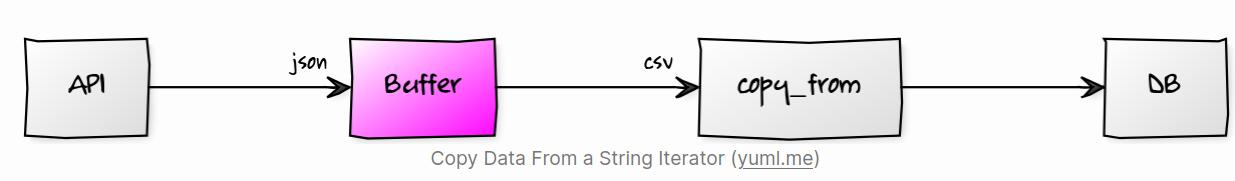

In [81]:
from typing import Iterator, Optional
import io

class StringIteratorIO(io.TextIOBase):
    def __init__(self, iter: Iterator[str]):
        self._iter = iter
        self._buff = ''

    def readable(self) -> bool:
        return True

    def _read1(self, n: Optional[int] = None) -> str:
        while not self._buff:
            try:
                self._buff = next(self._iter)
            except StopIteration:
                break
        ret = self._buff[:n]
        self._buff = self._buff[len(ret):]
        return ret

    def read(self, n: Optional[int] = None) -> str:
        line = []
        if n is None or n < 0:
            while True:
                m = self._read1()
                if not m:
                    break
                line.append(m)
        else:
            while n > 0:
                m = self._read1(n)
                if not m:
                    break
                n -= len(m)
                line.append(m)
        return ''.join(line)


To demonstrate how this works, this is how a CSV file-like object can be generated from a list of numbers:

In [77]:
gen = (f'{i},{i**2}\n' for i in range(3))
gen

<generator object <genexpr> at 0x7f161011b580>

In [78]:
f = StringIteratorIO(gen)
print(f.read())

0,0
1,1
2,4



Notice that we used f like a file. Internally, it fetched the rows from gen only when its internal line buffer was empty.

The loading function using StringIteratorIO looks like this:

In [79]:
@profile
def copy_string_iterator(connection, beers: Iterator[Dict[str, Any]]) -> None:
    with connection.cursor() as cursor:
        create_staging_table(cursor)
        beers_string_iterator = StringIteratorIO((
            '|'.join(map(clean_csv_value, (
                beer['id'],
                beer['name'],
                beer['tagline'],
                parse_first_brewed(beer['first_brewed']).isoformat(),
                beer['description'],
                beer['image_url'],
                beer['abv'],
                beer['ibu'],
                beer['target_fg'],
                beer['target_og'],
                beer['ebc'],
                beer['srm'],
                beer['ph'],
                beer['attenuation_level'],
                beer['brewers_tips'],
                beer['contributed_by'],
                beer['volume']['value'],
            ))) + '\n'
            for beer in beers
        ))
        cursor.copy_from(beers_string_iterator, 'staging_beers', sep='|')

The main difference is that the beers CSV file is consumed on demand, and the data is not stored in-memory after it was used.

Let's execute the function and see the results:

In [80]:
copy_string_iterator(connection, beers)


copy_string_iterator()
Time   0.3578
Memory 0.0078125


Great! Timing is low and memory is back to zero.

## Copy Data From a String Iterator with Buffer Size

In an attempt to squeeze one final drop of performance, we notice that just like page_size, the copy command also accepts a similar argument called size:

> _size – size of the buffer used to read from the file._

Let's add a size argument to the function:

In [85]:
@profile
def copy_string_iterator(connection, beers: Iterator[Dict[str, Any]], size: int = 8192) -> None:
    with connection.cursor() as cursor:
        create_staging_table(cursor)
        beers_string_iterator = StringIteratorIO((
            '|'.join(map(clean_csv_value, (
                beer['id'],
                beer['name'],
                beer['tagline'],
                parse_first_brewed(beer['first_brewed']).isoformat(),
                beer['description'],
                beer['image_url'],
                beer['abv'],
                beer['ibu'],
                beer['target_fg'],
                beer['target_og'],
                beer['ebc'],
                beer['srm'],
                beer['ph'],
                beer['attenuation_level'],
                beer['brewers_tips'],
                beer['contributed_by'],
                beer['volume']['value'],
            ))) + '\n'
            for beer in beers
        ))
        cursor.copy_from(beers_string_iterator, 'staging_beers', sep='|', size=size)


The default value for size is 8192, which is 2 ** 13, so we will keep sizes in powers of 2:

In [86]:
copy_string_iterator(connection, iter(beers), size=1024)


copy_string_iterator(size=1024)
Time   0.374
Memory 0.0


In [87]:
copy_string_iterator(connection, iter(beers), size=8192)


copy_string_iterator(size=8192)
Time   0.3271
Memory 0.0


In [88]:
copy_string_iterator(connection, iter(beers), size=16384)


copy_string_iterator(size=16384)
Time   0.3305
Memory 0.0


In [89]:
copy_string_iterator(connection, iter(beers), size=65536)


copy_string_iterator(size=65536)
Time   0.3296
Memory 0.0


Unlike the previous examples, it seems like there is no tradeoff between speed and memory. This makes sense because this method was designed to consume no memory. However, we do get different timing when changing the page size. For our dataset, the default 8192 is the sweet spot.

# Results Summary

A summary of the results:

|`Function`  |	`Time (seconds)` 	|` Memory (MB)`|
|-|-|-|
insert_one_by_one() | 128.8 (5.761) |	0.08203125 (0.0078125)
insert_executemany() |	124.7 |	2.765625
insert_executemany_iterator() |	129.3 |	0.0
insert_execute_batch()| 	3.917 |	2.50390625
insert_execute_batch_iterator(page_size=1) |	130.2 |	0.0
insert_execute_batch_iterator(page_size=100) |	4.333 |	0.0
insert_execute_batch_iterator(page_size=1000) |	2.537 |	0.2265625
insert_execute_batch_iterator(page_size=10000) |	2.585 |	25.4453125
insert_execute_values() |	3.666| 	4.50390625
insert_execute_values_iterator(page_size=1) |	127.4 |	0.0
insert_execute_values_iterator(page_size=100) |	3.677 |	0.0
insert_execute_values_iterator(page_size=1000)| 	1.468 |	0.0
insert_execute_values_iterator(page_size=10000) |	1.503 |	2.25
copy_stringio() |	0.6274 |	99.109375
copy_string_iterator(size=1024) |	0.4536 |	0.0
copy_string_iterator(size=8192) |	0.4596 |	0.0
copy_string_iterator(size=16384) |	0.4649 |	0.0
copy_string_iterator(size=65536) |	0.6171 |	0.0

# Summary
The big question now is What should I use? as always, the answer is It depends.

Each method has its own advantages and disadvantages, and is suited for different circumstances:

<div class="alert alert-info"
  <strong>TAKE AWAY:</strong> Prefer built-in approaches for complex data types.
</div>

Execute many, execute values and batch take care of the conversion between Python data types to database types. CSV approaches required escaping.

<div class="alert alert-info"
  <strong>TAKE AWAY:</strong> Prefer built-in approaches for small data volume.
</div>

The build-in approaches are more readable and less likely to break in the future. If memory and time is not an issue, keep it simple!

<div class="alert alert-info"
  <strong>TAKE AWAY:</strong> Prefer copy approaches for large data volume.
</div>


Copy approach is more suitable for larger amounts of data where memory might become an issue.

In [98]:
# dic = {"artist":"Survivor",
#  "auth":"Logged In",
#  "firstName":"Jayden",
#  "gender":"M",
#  "itemInSession":0,
#  "lastName":"Fox",
#  "length":245.36771,
#  "level":"free",
#  "location":"New Orleans-Metairie, LA",
#  "method":"PUT",
#  "page":"NextSong",
#  "registration":1541033612796.0,
#  "sessionId":100,
#  "song":"Eye Of The Tiger",
#  "status":200,
#  "ts":1541110994796,
#  "userAgent":"\"Mozilla\/5.0 (Windows NT 6.3; WOW64) AppleWebKit\/537.36 (KHTML, like Gecko) Chrome\/36.0.1985.143 Safari\/537.36\"",
#  "userId":"101"}

import json

with open('/home/alena/Documents/Udacity/data_engineer/code/project_data_modeling_psql/project-template/data/log_data/2018/11/2018-11-01-events.json') as f:
    users = json.load(f)

JSONDecodeError: Extra data: line 2 column 1 (char 457)

In [ ]:
@profile
def insert_execute_batch_iterator(connection, 
                                  beers: Iterator[Dict[str, Any]]) -> None:
    with connection.cursor() as cursor:
        create_staging_table(cursor)

        iter_users = ({
            **user #,
#             'ts': parse_first_brewed(beer['first_brewed']),
#             'volume': beer['volume']['value'],
        } for user in users)

        psycopg2.extras.execute_batch(cursor, """
            INSERT INTO users VALUES (
                %(userId)s,
                %(firstName)s,
                %(lastName)s,
                %(gender)s,
                %(level)s
            );
        """, iter_beers)